In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import irt2
from irt2.sampling import EID, Mention

from pathlib import Path
from pprint import pprint

import yaml
import numpy as np
import matplotlib.pyplot as plt


with (irt2.ENV.DIR.CONF / 'create' / 'cde-l.yaml').open(mode='r') as fd:
    config = yaml.load(fd, Loader=yaml.FullLoader)

pprint(config)

{'concept relations': ['P1412:languages spoken, written, or signed',
                       'P1303:instrument',
                       'P140:religion',
                       'P27:country of citizenship',
                       'P30:continent',
                       'P509:cause of death',
                       'P172:ethnic group',
                       'P2348:time period',
                       'P102:member of political party',
                       'P106:occupation',
                       'P495:country of origin',
                       'P136:genre',
                       'P641:sport',
                       'P19:place of birth',
                       'P69:educated at',
                       'P463:member of',
                       'P264:record label',
                       'P20:place of death',
                       'P1050:medical condition',
                       'P101:field of work',
                       'P2283:uses',
                       'P135:movement',
          

In [ ]:
# you can skip this part if mentions are cached (see below)
# GOTO: >>>

from irt2 import sampling

# create index of sampling.Match instances
# an optional cache speeds up load time

# this might take a while
# irt.cde.matches-full requires around 24G RAM
idx_matches = sampling.load_index_matches(
    path=irt2.ENV.DIR.ROOT / config['source matches'],
    invalidate_cache=False,
)

print('\nmatch index:')
print(f'  total: {len(idx_matches.flat)}')
print(f'  pages: {len(idx_matches.keys("page"))}')
print(f'   eids: {len(idx_matches.keys("eid"))}')

In [ ]:
# plot how matches distribute over entities

def plot_dist(
    y,
    title: str,
    subtitle: str,
    filenames: list[Path] = None,
):
    fig, ax = plt.subplots()
    fig.suptitle(title)

    ax.set_title(subtitle, color='#999')
    ax.set_yscale('log')

    ax.plot(np.arange(len(y)), y, color='#666')

    if filenames:
        for filename in filenames:
            fig.savefig(filename)


def plot_distribution_idx(index, **kwargs):

    lens = {}
    for eid in index.keys('eid'):
        n = len(index.dis(eid=eid))
        lens[eid] = n

    lens = sorted(((n, eid) for eid, n in lens.items()), reverse=True)
    y = np.array([n for n, _ in lens])

    plot_dist(y=y, **kwargs)
    return y


cde_y = plot_distribution_idx(
    index=idx_matches,
    title="Matches Count",
    subtitle="{config['source graph']} ({config['source name']})",
    # filenames=[
    #     ... / f'irt.cde.matches-distribution.{suff}'
    #     for suff in ('png', 'svg')
    # ],
)

In [ ]:
print(f"\nmapping EIDS to mentions")
print(f"pruning at threshold: {config['prune mentions']}")

mentions: dict[EID, dict[Mention, int]]
norm2mentions: dict[str, str]

norm2mentions, mentions = sampling.get_mentions(
    index=idx_matches,
    prune=config['prune mentions'],
)

print(f'retained {len(mentions)} mentions')

In [ ]:
# some example mentions

def print_mention_counts(mentions, eid):
    for mention, count in sorted(mentions[eid].items(), key=lambda t: t[1], reverse=True):
        print(f"{count:5d} {mention}" )
    print()


print_mention_counts(mentions=mentions, eid='Q11708')
print_mention_counts(mentions=mentions, eid='Q49297')
print_mention_counts(mentions=mentions, eid='Q21077')

In [ ]:
# entities with most mentions
for eid, mdic in sorted(mentions.items(), key=lambda t: len(t[1]), reverse=True)[:20]:
    print(len(mdic), eid, list(idx_matches.get(eid=eid))[0].entity)

In [3]:
# >>>

# idx_matches is no longer required
# start here if mentions are cached

import pickle
from ktz.string import args_hash
from typing import Any

def cached_mentions(
        source_matches,
        prune_mentions,
        data: Any = None,
):
    hash = args_hash(source_matches, prune_mentions)
    cachefile = f"create.ipynb.mentions.{hash}.pkl"
    cache = irt2.ENV.DIR.CACHE / cachefile

    try:
        data = norm2mentions, mentions  # raises NameError
        print('saving mentions to cache')

        with cache.open(mode='wb') as fd:
            pickle.dump(data, fd)

        return data

    except NameError:
        print('loading from cache')
        with cache.open(mode='rb') as fd:
            return pickle.load(fd)


norm2mentions, mentions = cached_mentions(
    source_matches=config['source matches'],
    prune_mentions=config['prune mentions'],
)

loading from cache


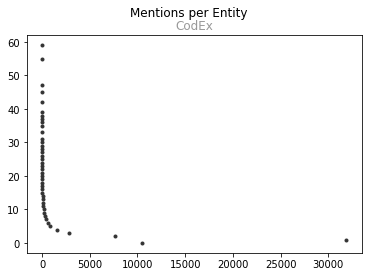

In [4]:
from collections import Counter


def plot_mention_counts(mentions, title, subtitle, **kwargs):
    counts = Counter()
    for countdic in mentions.values():
        counts[len(countdic)] += 1

    y, x = zip(*sorted(counts.items()))

    fig, ax = plt.subplots()
    fig.suptitle(title)
    ax.set_title(subtitle, color='#999')

    ax.scatter(x, y, **kwargs)



plot_mention_counts(
    mentions=mentions,
    title="Mentions per Entity",
    subtitle=config['source name'],
    color='#333',
    marker='.',
)

In [5]:
from irt2.graph import Graph
from irt2.graph import load_graph


graph = load_graph(
    config['graph loader'],
    config['graph name'],
    *[irt2.ENV.DIR.ROOT / path for path in config['graph loader args']],
    **{k: irt2.ENV.DIR.ROOT / path for k, path in config['graph loader kwargs'].items()},
)


print(graph.description)

IRT2 GRAPH: CodEx-M
  nodes: 17050
  edges: 206205 (51 types)
  degree:
    mean 24.19
    median 13



In [6]:
# plan:
#  - select all mentions of concept entities
#  - shuffle and split remaining mentions randomly
#  - assign vertices based on mention split to be either cw or ow
#  - assign triples based on vertex split


from irt2.sampling import split_mentions
from tabulate import tabulate


print(f"targeting {config['target mention split'] * 100}% closed-world mentions:\n")

split = split_mentions(
    graph,
    mentions=mentions,
    seed=config['seed'],
    ratio=config['target mention split'],
    concept_rels=config['concept relations'],
    include_rels=config['include relations'],
    exclude_rels=config['exclude relations'],
)


print('running self-check...')
split.check()
print('self-check passed')


print(tabulate((
    (
        'concept',
        -1,
        len(split.concept_vertices),
        len(split.concept_triples),
    ), (
        'closed world',
        len(split.closed_world_mentions),
        len(split.closed_world_vertices),
        len(split.closed_world_triples),
    ), (
        'open world',
        len(split.open_world_mentions),
        len(split.open_world_vertices),
        len(split.open_world_triples),
    ), (
        'open world heads',
        -1,
        -1,
        len(split.open_world_head_triples),
    ),
    (
        'open world tails',
        -1,
        -1,
        len(split.open_world_tail_triples),
    ),
), headers=('', 'mentions', 'vertices', 'triples')))

print(f'retained {len(split.relations)} relations')


targeting 70.0% closed-world mentions:



running self-check...
self-check passed


                    mentions    vertices    triples
----------------  ----------  ----------  ---------
concept                   -1        2489      11370
closed world           22867        9896     158892
open world              9799        5124       1858
open world heads          -1          -1      57007
open world tails          -1          -1       4730
retained 46 relations


In [19]:
from irt2.sampling import split2irt2

dataset = split2irt2(config, split)
print(str(dataset))

IRT2/CDE-L: 15020 vertices | 47 relations | 32666 mentions
